# Task 2.2C
### Joshua Sansom-Sherwill - #220013964

## 1. Introduction
In this exercise I hope to demonstrate the tradeoff between exploration & exploitation with respect to Reinforcement Learning and action-reward mapping with Q-Values.
I will be focusing on a maze environment and designing agents to solve this maze using firstly a random exploration strategy, and then secondly an e-greedy exploration/exploitation strategy, and lastly an optimistic selection strategy.

I will then conclude by assessing the results of these different strategies.

## 2. Environment & Runner
Below we will create our envioronment, and a runner that has parameters so we can compare the key differences between strategies.


In [ ]:
!pip install gym-maze-trustycoder83

In [83]:
import numpy as np
import gym
import gym_maze
from gym import wrappers
import os

os.environ["SDL_VIDEODRIVER"] = "dummy"

def run_maze(create_policy):

    # Maze environment
    env = gym.make("maze-sample-10x10-v0")

    current_state = env.reset()

    policy = create_policy(action_space = env.action_space, maze_shape = (10,10))

    # Number of episode we will run
    n_episodes = 10

    # Maximum of iteration per episode
    max_iter_episode = 500

    # Iterate over episodes
    for e in range(n_episodes):
        
        # We are not done yet
        done = False
        
        # Sum the rewards that the agent gets from the environment
        policy.rewards_tracker.append([])

        for i in range(max_iter_episode): 

            action = policy.get_action(current_state)

            next_state, reward, done, _ = env.step(action)

            policy.update(current_state, action, reward, next_state)
            policy.rewards_tracker[e].append(reward)

            # If the episode is finished, we leave the for loop
            if done:
                break
            current_state = next_state
        
        #Reset enviroment for next episode
        current_state = env.reset()

    return policy

## 3. Strategy Comparison

### 3.1 Random Explore
For our random explore strategy, I have created a policy class based with a Q-learning table.
The basic idea of this strategy is that it will use the q-learning table to exploit 50% of the time, and explore the other 50% of the time.


In [84]:
class QLearningPolicy():
    def __init__(self, action_space, maze_shape):
        self.epsilon = 0.5
        self.gamma = 1
        #dictionary to keep the states/coordinates of the Q table
        self.action_space = action_space
        self.states_dic = {} 
        count = 0
        for i in range(maze_shape[0]):
            for j in range(maze_shape[1]):
                self.states_dic[i, j] = count
                count+=1
        # Initialize the Q-table to 0|
        self.Q_table = np.zeros((len(self.states_dic), self.action_space.n))
        self.learning_rate_table = np.ones((len(self.states_dic), self.action_space.n))

        # a matrix for tracking rewards over time for every eppisode
        self.rewards_tracker = []

    # Choose next action
    def get_action(self, current_state):
        current_Q_table_coordinates = self._get_qtable_coordinates(current_state)

        if np.random.uniform(0,1) < self.epsilon:
            return self.action_space.sample()
        
        return int(np.argmax(self.Q_table[current_Q_table_coordinates]))

    # Qlearning update
    def update(self, current_state, action, reward, next_state):
        current_qtable_lookup = self._get_qtable_coordinates(current_state)
        old_estimate = self.Q_table[current_qtable_lookup, action]
        # because our reward value is just negative for every step taken, and finally a 1
        # for our reward state, we need to include our potential reward as part of the qvalue
        # calculations
        potential_reward = max(self.Q_table[self._get_qtable_coordinates(next_state),:])
        
        # we calculate our target using a greedy action
        # from the potential future rewards
        target = (reward + potential_reward)

        learning_rate = 1/self.learning_rate_table[current_qtable_lookup, action]

        # New estimate of reward for action
        self.Q_table[current_qtable_lookup, action] = old_estimate + learning_rate*(target-old_estimate)
        self._update_learning_rate(current_qtable_lookup, action)


    def _get_qtable_coordinates(self, state):
        x = int(state[0])
        y = int(state[1])
        return self.states_dic[x, y]
    
    def _update_learning_rate(self, index, action):
        self.learning_rate_table[index, action] += 1



Below is the result of running our maze environment defined earlier with our RandomExplorePolicy class.

In [85]:
random_explore_policy = run_maze(lambda action_space, maze_shape: QLearningPolicy(action_space, maze_shape))

In [86]:
import matplotlib.pyplot as plt

def get_average_reward(all_rewards):
    
    max_length = max(map(lambda x: len(x), all_rewards))
    average_reward = np.zeros(max_length)

    for rewards in all_rewards:
        # create arrays with the same length
        filled_array = np.array([rewards[x] if x < len(rewards) else 1 for x in range(max_length)])
        # calculate average reward for the iterations
        average_reward += filled_array

    average_reward /= len(all_rewards)
    return average_reward

Text(0.5, 0, 'Number of Steps')

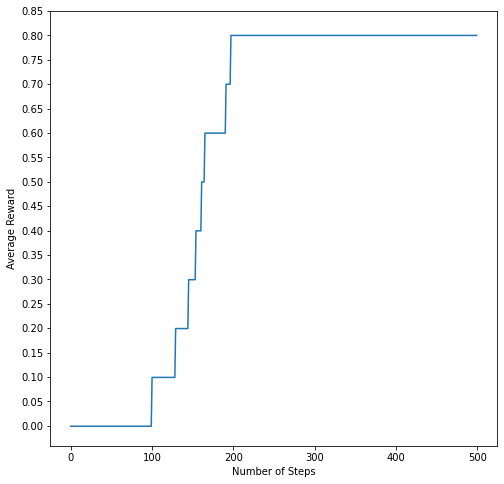

In [87]:
average_reward = get_average_reward(random_explore_policy.rewards_tracker)

fig, axes = plt.subplots(figsize=(8,8))
axes.plot([x for x in range(len(average_reward))], average_reward, label="Random Exploration")
axes.set_yticks(np.arange(0,max(average_reward) + 0.1, 0.05))
axes.set_ylabel("Average Reward")
axes.set_xlabel("Number of Steps")

### 3.2 Epsilon-Greedy Explore
Epsilon greedy strategies allow us to strike a balance between expliration and exploitation.
When epsilon is high, we favor exploration, and when epsilon is low, we favor exploitation [[1]].

Below is an epsilon greedy version of the same agent as above, where epsilon is rotated to find the best value of epsilon.
The other value that we also rotate at this point is gamma. Gamma is used to control degree to which old reward is considered vs new reward.

In [88]:
def create_epsilon_greedy(action_space, maze_shape, epsilon, gamma):
    policy = QLearningPolicy(action_space, maze_shape)
    policy.epsilon = epsilon
    policy.gamma = gamma
    return policy

In [89]:
epsilon_policies = []
epsilon_options = [0.3, 0.1, 0.01]
gamma_options = [1, 0.8, 0.5]

for epsilon in epsilon_options:
    for gamma in gamma_options:
        create_policy = lambda action_space, maze_shape: create_epsilon_greedy(action_space, maze_shape, epsilon, gamma)
        policy = run_maze(create_policy)
        epsilon_policies.append(policy)


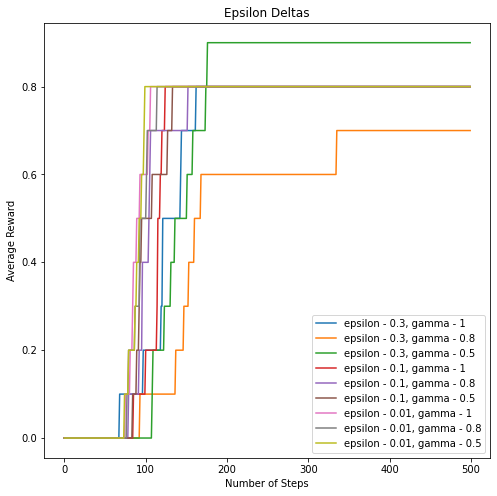

In [90]:

fig, axes = plt.subplots(figsize=(8,8))
plt.title("Epsilon Deltas")
axes.set_ylabel("Average Reward")
axes.set_xlabel("Number of Steps")

index = 0
for policy in epsilon_policies:
    average_reward = get_average_reward(policy.rewards_tracker)
    axes.plot([x for x in range(len(average_reward))], average_reward, label="epsilon - {0}, gamma - {1}".format(policy.epsilon, policy.gamma))
    index +=1

axes.legend()



### 3.3 Optimistic Initialisation
Another way of improving the outcome of an agent given some prior knowledge of the enviornment initialize the Q values to manipulate the way the agent is going to explore the environment [[2]].

In this case, setting the initial values to "1" means that the agent will explore by means of its greedy action selection, we are again going to be looking at a few values for epsilon in order to see how the initial values might affect learning efficiency.
 


In [91]:
# creation function for our optimistic initial value selection strategy
def create_optimistic_selection(action_space, maze_shape, epsilon, gamma):
    policy = QLearningPolicy(action_space, maze_shape)
    policy.epsilon = epsilon
    policy.gamma = gamma
    policy.Q_table[:,:] = 1
    return policy

In [92]:
optimistic_policies = []
optimistic_epsilons = [0, 0.3, 0.1, 0.01]
for epsilon in optimistic_epsilons:
    for gamma in gamma_options:
        policy = run_maze(lambda action_space, maze_shape: create_optimistic_selection(action_space, maze_shape, epsilon, gamma))
        optimistic_policies.append(policy)

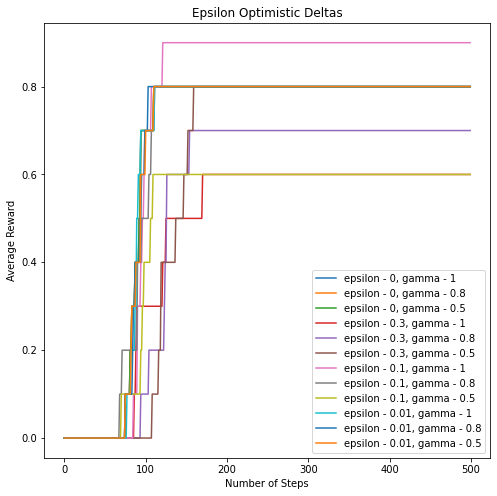

In [93]:

# Create a figure of all our results from optimistic inital value policies

fig, axes = plt.subplots(figsize=(8,8))
plt.title("Epsilon Optimistic Deltas")
axes.set_ylabel("Average Reward")
axes.set_xlabel("Number of Steps")

index = 0
for policy in optimistic_policies:
    average_reward = get_average_reward(policy.rewards_tracker)
    axes.plot([x for x in range(len(average_reward))], average_reward, label="epsilon - {0}, gamma - {1}".format(policy.epsilon, policy.gamma))
    index +=1

axes.legend()



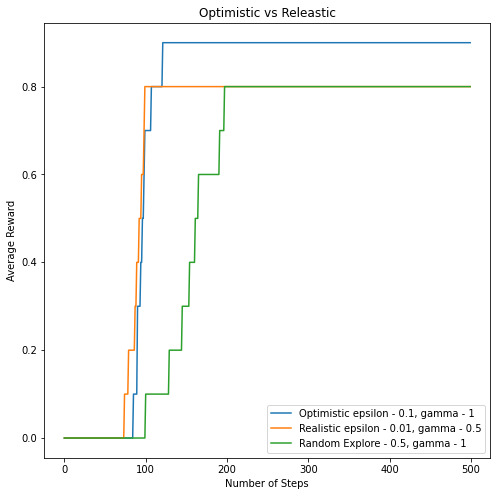

In [94]:

# we define "best" by finding the policy that
# finished faster than the other policies
def get_best(policies):
    max_length = 0
    for policy in all_policies:
        for rewards in policy.rewards_tracker:
            max_length = len(rewards) if len(rewards) > max_length else max_length


    best_average = 0
    best_policy = None
    for policy in policies:
        average_reward = get_average_reward(policy.rewards_tracker)
        average_reward = np.array([average_reward[x] if x < len(average_reward) else 1 for x in range(max_length)])
        if np.sum(average_reward) > best_average:
            best_average = np.sum(average_reward)
            best_policy = policy
    
    return best_policy


#Create a plot showing progression of all average rewards for all policies in order to compare performance
fig, axes = plt.subplots(figsize=(8,8))
plt.title("Optimistic vs Releastic")
axes.set_ylabel("Average Reward")
axes.set_xlabel("Number of Steps")

max_length = 0
best_optimistic = get_best(optimistic_policies)
best_epsilon = get_best(epsilon_policies)
all_policies = [best_optimistic, best_epsilon, random_explore_policy]

for policy in all_policies:
    for rewards in policy.rewards_tracker:
        max_length = len(rewards) if len(rewards) > max_length else max_length

index = 0
for policy in all_policies:
    average_reward = get_average_reward(policy.rewards_tracker)
    label = ""
    if index < 1:
        label = "Optimistic epsilon - {0}, gamma - {1}".format(policy.epsilon, policy.gamma)
    elif index == 1:
        label = "Realistic epsilon - {0}, gamma - {1}".format(policy.epsilon, policy.gamma)
    else:
        label = "Random Explore - {0}, gamma - {1}".format(policy.epsilon, policy.gamma)

    axes.plot([x for x in range(len(average_reward))], average_reward, label=label)
    index +=1



axes.legend()



## 4. Conclusion
From the above tests we are able to see that the results of the different strategies.
For Random Exploration and Epsilon Greedy, we can see that decreasing the value of epsilon had the effect of reducing random exploration and as a result the agents seemed learn faster.

Secondly, when looking at Optimistic selection we were able to see that using an optimistic initial value allowed the agent to explore more naturally and learn at faster rates with no random exploration using epsilon at all.

Finally comparing both epsilon greedy and optimistic intialisation strategies shows the optimistic approach to have the fastest initial learning efficiency within this maze environment.

Because we have a low variance in available rewards our results favour a more greedy approach, however in other less deterministic scenarios it might be more appropriate to have an epsilon greedy approach for more exploration. [[3]]

## 5. References
1. Sutton RS, Barto AG. Reinforcement Learning, Second Edition : An Introduction. Cambridge: MIT Press; 2018. ch 2, pp. 64
2. Sutton RS, Barto AG. Reinforcement Learning, Second Edition : An Introduction. Cambridge: MIT Press; 2018. ch 2, pp. 66
3. Sutton RS, Barto AG. Reinforcement Learning, Second Edition : An Introduction. Cambridge: MIT Press; 2018. ch 2, pp. 61